Bộ dữ liệu chạy thử nghiệm là bộ dl lấy trong bài báo Improving protein succinylation sites prediction using embeddings from protein language model
link: https://www.nature.com/articles/s41598-022-21366-2

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle as cPickle

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional, LSTM, SimpleRNN, Input, GRU
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Dropout, Activation, MaxPooling1D,Conv1D
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.initializers import glorot_uniform
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score,roc_auc_score
import sklearn.metrics as metrics
from keras import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
path_test = "/content/drive/MyDrive/CBiLSuccSite/Data/Test/"
path_result = "/content/drive/MyDrive/CBiLSuccSite/Result/"
path_model ="/content/drive/MyDrive/CBiLSuccSite/Model/"
filename_test = "test_data.csv"

In [18]:
file_test = filename_test
df_test= pd.read_csv(path_test + filename_test,  delimiter= ',')

In [ ]:
#def Dictionary for 1-gram
def Dic_1_gram():
    AA_list_sort = ['G','A','V','L','I','M','P','F','W','S','T','N','Q','Y','C','K','R','H','D','E','X']

    AA_dict = {}
    numm = 1
    for i in AA_list_sort:
        AA_dict[i] = numm
        numm += 1
    return AA_dict
# Separation of words in protein sequence
def ProSentence(pro, K):
	sentence = ""
	length = len(pro)
	for i in range(length - K + 1):
		sentence += pro[i: i + K] + " "
    #delete extra space
	sentence = sentence[0 : len(sentence) - 1]
	return sentence

In [19]:
k =1#1-gram
word_index1 =  Dic_1_gram()
vocab_size = len(word_index1)

In [20]:
# Prepocessing test data
text_test =[] #PTMsequend kmer
for i in df_test['Sequence']:
  temp = ProSentence(i,k)
  text_test.append(temp)
df_test['k_mer'] =text_test
test_sequences = []
for each in text_test:
    each_index_list = []
    each = each.split(' ')
    for i in each:
        each_index_list.append(word_index1[i])
    test_sequences.append(each_index_list)
data_token = []
for i in df_test['k_mer']:
   data_token.append(i.split())
MAX_SEQUENCE_LENGTH = len(data_token[1])
Xtest = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
ytest= df_test['Label']

In [21]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, accuracy_score,roc_auc_score
import sklearn.metrics as metrics
from keras import models
model = models.load_model(path_model +"Suci_CNN_BiLSTM.h5")
y_pred = model.predict([Xtest,Xtest])

y_pred = (y_pred > 0.5)

y_pred = [int(i) for i in y_pred]

y_pred = np.array(y_pred)
y_true = np.array(ytest)

cm = confusion_matrix(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
acc = accuracy_score(y_true, y_pred)

sn = cm[1][1]/(cm[1][1]+cm[1][0])
sp = cm[0][0]/(cm[0][0]+cm[0][1])
print('ACC, MCC, SN, SP:',acc, mcc,sn,sp)
print(cm)




16/16 [==============================] - 2s 4ms/step
ACC, MCC, SN, SP: 0.7633136094674556 0.5283454370521207 0.8023715415019763 0.7244094488188977
[[184  70]
 [ 50 203]]


<ipython-input-21-e44cc00712d6>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred = [int(i) for i in y_pred]


16/16 [==============================] - 1s 4ms/step
AUC: 0.8183


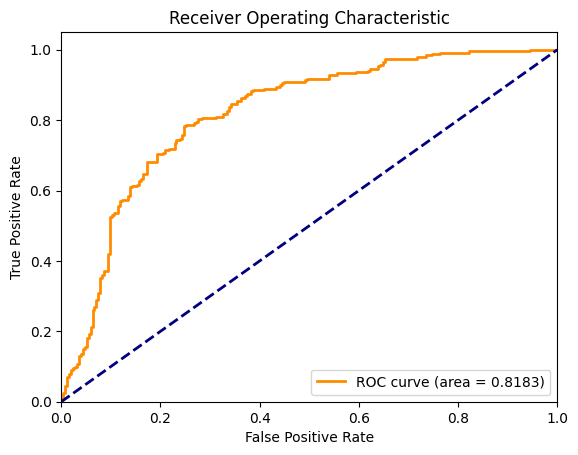

In [22]:
model = models.load_model(path_model +"Suci_CNN_BiLSTM.h5")
y_pred_proba = model.predict([Xtest,Xtest])

# Tính toán AUC
auc = roc_auc_score(ytest, y_pred_proba)
print(f'AUC: {auc:.4f}')

# Tính toán đường ROC
fpr, tpr, thresholds = roc_curve(ytest, y_pred_proba)

# Vẽ biểu đồ ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()